# sequence prediction sandbox


In [1]:
import torch
from torch import nn

from collections import defaultdict
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
def kmers(k):
    return [''.join(x) for x in product(['A','C','G','T'], repeat=k)]

def count_kmers_in_seq(seq, mers):
    '''
    For a given sequence and kmer set, return the count
    '''
    return [seq.count(mer) for mer in mers]

seqs8 = kmers(8)
print('Total 8mers:',len(seqs8))

Total 8mers: 65536


In [3]:
# if you want to down select
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}

def mode0(seq):
    '''Ignore motifs, just return average score'''
    return np.mean([score_dict[base] for base in seq])

def mode1(seq):
    '''Return average score, TAT gets +10, GCG gets -10'''
    score = np.mean([score_dict[base] for base in seq])
    if 'TAT' in seq:
        score += 10
    if 'GCG' in seq:
        score -= 10
        
    return score

def mode2(seq):
    '''Return average score, GCG gets +10, TAT gets -10'''
    score = np.mean([score_dict[base] for base in seq])
    if 'GCG' in seq:
        score += 10
    if 'TAT' in seq:
        score -= 10
        
    return score
    

modes = {
    0: mode0,
    1: mode1,
    2: mode2,
}
                  
def score_seqs_multi(seqs, mode_list):
    '''
    Mode 0: ignore motifs
    Mode 1: TAT is high, GCG is low
    Mode 2: GCG is high, TAT is low
    '''
    data = []
    for seq in seqs:
        scores = []
        for mode in mode_list:
            score = modes[mode](seq) # call the mode function
            scores.append(score)
        data.append([seq]+scores)
    
    cols = ['seq'] + [f"mode{m}" for m in mode_list]
        
    df = pd.DataFrame(data, columns=cols)
    return df


In [5]:
multi_df = score_seqs_multi(seqs8,[0,1,2])

In [6]:
multi_df[multi_df['seq']=='AATATAAA']

,seq,mode0,mode1,mode2
3264,AATATAAA,17.75,27.75,7.75


In [7]:
multi_df[multi_df['seq']=='AAGCGATA']

,seq,mode0,mode1,mode2
2444,AAGCGATA,17.0,7.0,27.0


In [8]:
multi_df.head()

,seq,mode0,mode1,mode2
0,AAAAAAAA,20.000,20.000,20.000
1,AAAAAAAC,19.625,19.625,19.625
2,AAAAAAAG,19.250,19.250,19.250
3,AAAAAAAT,18.875,18.875,18.875
4,AAAAAACA,19.625,19.625,19.625


### Define some Custom Dataset/Dataloader functions

In [9]:
from torch.utils.data import TensorDataset,DataLoader,Dataset
import random
random.seed(7)

In [10]:
class MultiTaskDatasetOHE(Dataset):
    '''
    Multi-task for one-hot-encoded sequences
    '''
    def __init__(self,df):
        self.seqs = list(df['seq'])
        self.seq_len = len(self.seqs[0])
    
        self.label0 = list(df['mode0'])
        self.label1 = list(df['mode1'])
        self.label2 = list(df['mode2'])
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        seq = torch.tensor(u.one_hot_encode(self.seqs[idx]))
        
        label0 = torch.tensor(float(self.label0[idx]))
        label1 = torch.tensor(float(self.label1[idx]))
        label2 = torch.tensor(float(self.label2[idx]))
        
        return seq, (label0, label1, label2)

    
class MultiTaskDatasetKmer(Dataset):
    '''
    Multi-task for k-mer frequencies
    '''
    def __init__(self,df,k):
        self.seqs = list(df['seq'])
        self.seq_len = len(self.seqs[0])
        self.kmers = kmers(k)
    
        self.label0 = list(df['mode0'])
        self.label1 = list(df['mode1'])
        self.label2 = list(df['mode2'])
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        kmer_vec = torch.tensor(count_kmers_in_seq(self.seqs[idx],self.kmers))
        
        label0 = torch.tensor(float(self.label0[idx]))
        label1 = torch.tensor(float(self.label1[idx]))
        label2 = torch.tensor(float(self.label2[idx]))
        
        return kmer_vec, (label0, label1, label2)

In [11]:
def quick_load_and_split_input(df, split_frac=0.8, verbose=False):
    '''
    Given a df, randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    '''

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df, test_df


class DatasetSpec():
    '''
    Quick access class for speciying the type of dataset to build
    '''
    def __init__(self,ds_type,k=None):
        self.name = ds_type
        self.k = k
        
        self.id = self.name if not k else f"{self.name}_{k}"
    

def build_dataloaders(df,ds_types,batch_size=32):
    '''
    Given an input dataframe and a list of dataset types, assemble them into 
    a dictionary of DataLoaders
    '''
    # train test split
    train_df, test_df = quick_load_and_split_input(df)
    
    dls = {} # collect data loaders
    
    # figure out which DataSetTypes needed
    for ds_type in ds_types:
        # Kmer data set
        if ds_type.name == 'multi_kmer':
            if not ds_type.k:
                raise ValueError(f"To use multi_kmer Dataset, you must specify an integer value for k in DatasetSpec")
            assert(type(ds_type.k) == int)

            train_ds = MultiTaskDatasetKmer(train_df,ds_type.k)
            test_ds = MultiTaskDatasetKmer(test_df,ds_type.k)

        # One-hot encoded dataset
        elif ds_type.name == 'multi_ohe':
            train_ds = MultiTaskDatasetOHE(train_df)
            test_ds = MultiTaskDatasetOHE(test_df)

        # unknown datatype?
        else:
            raise ValueError(f"Unknown Dataset Type {ds_type}.")
        
        # Put DataSets into DataLoaders
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
        dls[ds_type.id] = (train_dl,test_dl)
    
    return train_df,test_df, dls

In [12]:
dataset_types = [
    DatasetSpec('multi_ohe'),
    DatasetSpec('multi_kmer',k=1),
    DatasetSpec('multi_kmer',k=3),
    DatasetSpec('multi_kmer',k=6),
]

train_df, test_df, dls = build_dataloaders(multi_df,dataset_types)
dls

{'multi_ohe': (<torch.utils.data.dataloader.DataLoader at 0x7f69ab8d8cd0>,
  <torch.utils.data.dataloader.DataLoader at 0x7f69ab8d8a30>),
 'multi_kmer_1': (<torch.utils.data.dataloader.DataLoader at 0x7f69ab8d8ee0>,
  <torch.utils.data.dataloader.DataLoader at 0x7f69ab8d8f70>),
 'multi_kmer_3': (<torch.utils.data.dataloader.DataLoader at 0x7f69b075b400>,
  <torch.utils.data.dataloader.DataLoader at 0x7f69b075b9d0>),
 'multi_kmer_6': (<torch.utils.data.dataloader.DataLoader at 0x7f69b075b070>,
  <torch.utils.data.dataloader.DataLoader at 0x7f69ab8dc280>)}

In [13]:
dls['multi_kmer_1'][0].dataset.kmers

['A', 'C', 'G', 'T']

### Define Loss and FIt functions

In [14]:
def get_loss_for_condition_average(train_df, test_df, conditions, loss_func):
    '''
    For any sequence, just predict the average of all the training sequences
    scores in that condition. (Basically a column average of that condition in 
    the training set). Since it's not learning over time, this will just be 
    a flat score. Calculate the loss between the actual test set target values
    and this average value. Use this loss as a reference for other models' losses
    over time.
    '''
    # get average score by condition from train df
    losses = []
    for cond in conditions:
        # average from train df
        pred = np.mean(train_df[cond].values)
        
        # target vec from test df
        target_vec = torch.tensor(test_df[cond].values)
        pred_vec = torch.tensor([pred for x in target_vec])
        
        cond_loss = loss_func(pred_vec, target_vec)
        losses.append(cond_loss)
    
    # combine losses from each condition
    loss = torch.mean(torch.stack(losses))
    
    
    return loss.item()
    

In [15]:
# just get loss from predicting average (should be not good cuz not learning anything)
conds = ['mode0','mode1','mode2']
loss_func = torch.nn.MSELoss()
ave_pd_loss = get_loss_for_condition_average(train_df, test_df, conds, loss_func)
ave_pd_loss

13.100788400308923

In [16]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    #print("in Loss Batch...")
    obj0_target = yb[0].unsqueeze(1).float()
    obj1_target = yb[1].unsqueeze(1).float()
    obj2_target = yb[2].unsqueeze(1).float()
    # need unsqueeze otherwise dimension mismatch? [32] vs [32,1]

    
    #loss = loss_func(model(xb.float()), yb.float())
    # yb is a list of tensors... what should it be?
    # how to adapt loss for multi-task?
    #print("yb[0]:", yb[0])
    
    # try looping through ybs?
    res = model(xb.float()) # get predictions? returns list
    
    loss_obj0 = loss_func(res[0], obj0_target)
    loss_obj1 = loss_func(res[1], obj1_target)
    loss_obj2 = loss_func(res[2], obj2_target)
    
    #loss = sum([loss_obj0, loss_obj1, loss_obj2])/3
    loss = torch.mean(torch.stack([loss_obj0, loss_obj1, loss_obj2]))
#     print("what is 'loss'?:")
#     print("0:",loss_obj0)
#     print("1:",loss_obj1)
#     print("2:",loss_obj2)
#     print("all:",loss)
#     print("*****")

    if opt is not None:
        opt.zero_grad() # order? should this be first? last?
        loss.backward()
        opt.step()
        

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        print('Epoch:',epoch)
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            t, n = loss_batch(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
                # Note: no opt provided, backprop won't happen
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

## Define model types

In [17]:
class DNA_Linear_Multi(nn.Module):
    def __init__(self,seq_len,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(h2_size,1)
        self.obj1  = nn.Linear(h2_size,1)
        self.obj2  = nn.Linear(h2_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin_share(xb)
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)

class Kmer_Linear_Multi(nn.Module):
    def __init__(self,num_kmers,h1_size,h2_size):
        super().__init__()
        
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(num_kmers, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(h2_size,1)
        self.obj1  = nn.Linear(h2_size,1)
        self.obj2  = nn.Linear(h2_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin_share(xb)
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)
    
    
DATASET_TYPES = {
    'multi_ohe':MultiTaskDatasetOHE,
    'multi_kmer':MultiTaskDatasetKmer,
}
    

## try linear kmer model

Epoch: 0


/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


0 6.50613686243208
Epoch: 1
1 0.4089087842348912
Epoch: 2
2 0.3279210403811688
Epoch: 3
3 0.30188210019804845
Epoch: 4
4 0.29370142972829466
Epoch: 5
5 0.28636362625761735
Epoch: 6
6 0.2751292954012865
Epoch: 7
7 0.27238835913217535
Epoch: 8
8 0.26693578555084124
Epoch: 9
9 0.26233485339253204


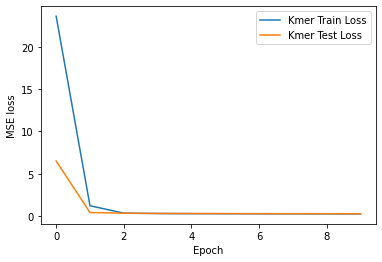

In [18]:
h1 = 10
h2 = 10
train_dl,test_dl = dls['multi_kmer_3']

num_kmers = len(train_dl.dataset.kmers)

kmer_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer_lin_model.parameters(), lr=0.001) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer_lin_data_label = list(zip([train_losses,val_losses], ['Kmer Train Loss','Kmer Test Loss']))
u.quick_loss_plot(kmer_lin_data_label)

In [19]:
# check out model??
kmer_lin_model

Kmer_Linear_Multi(
  (lin_share): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU(inplace=True)
  )
  (obj0): Linear(in_features=10, out_features=1, bias=True)
  (obj1): Linear(in_features=10, out_features=1, bias=True)
  (obj2): Linear(in_features=10, out_features=1, bias=True)
)

In [20]:
lin = kmer_lin_model.lin_share[0]
w = lin.weight
x = sum(w)

xdf = pd.DataFrame(list(zip(train_dl.dataset.kmers, [y.item() for y in x])), columns=['mer','w'])
xdf.sort_values('w').tail(30)

,mer,w
17,CAC,0.254673
48,TAA,0.257811
46,GTG,0.265103
9,AGC,0.269297
16,CAA,0.271507
36,GCA,0.277990
18,CAG,0.278012
8,AGA,0.283346
29,CTC,0.295209
10,AGG,0.305239


### k=1

Epoch: 0
0 10.640180298930666
Epoch: 1
1 9.12790181326146
Epoch: 2
2 8.990729671882209
Epoch: 3
3 9.011826345532779
Epoch: 4
4 8.903984921641346
Epoch: 5
5 9.136562308706377
Epoch: 6
6 8.858845266075006
Epoch: 7
7 8.861689811441133
Epoch: 8
8 8.8175568177564
Epoch: 9
9 8.924191414382278


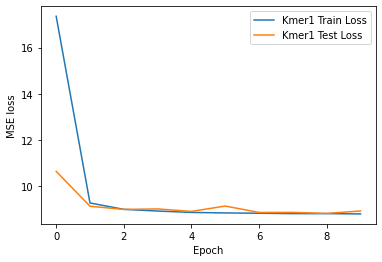

In [21]:
train_dl,test_dl = dls['multi_kmer_1']

num_kmers = len(train_dl.dataset.kmers)

kmer1_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer1_lin_model.parameters(), lr=0.001) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer1_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer1_lin_data_label = list(zip([train_losses,val_losses], ['Kmer1 Train Loss','Kmer1 Test Loss']))
u.quick_loss_plot(kmer1_lin_data_label)

### k=6

Epoch: 0
0 12.870003970032391
Epoch: 1
1 12.631612822236104
Epoch: 2
2 12.404778592863714
Epoch: 3
3 12.173525350429243
Epoch: 4
4 12.00317673818491
Epoch: 5
5 11.89160311407602
Epoch: 6
6 11.856544885323984
Epoch: 7
7 11.805997430023202
Epoch: 8
8 11.778723060630028
Epoch: 9
9 11.742831664220713


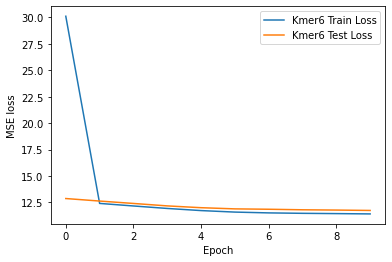

In [22]:
train_dl,test_dl = dls['multi_kmer_6']

num_kmers = len(train_dl.dataset.kmers)

kmer6_lin_model = Kmer_Linear_Multi(num_kmers, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(kmer6_lin_model.parameters(), lr=0.001) 

epochs = 10
train_losses, val_losses = fit(epochs, kmer6_lin_model, loss_func, optimizer, train_dl, test_dl)

kmer6_lin_data_label = list(zip([train_losses,val_losses], ['Kmer6 Train Loss','Kmer6 Test Loss']))
u.quick_loss_plot(kmer6_lin_data_label)

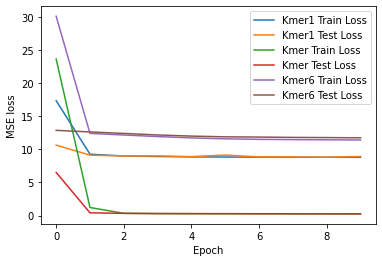

In [24]:
u.quick_loss_plot(kmer1_lin_data_label+kmer_lin_data_label+kmer6_lin_data_label)

## try linear OHE model

In [25]:
h1 = 10
h2 = 10
seq_len = len(train_df['seq'][0])
seq_len

8

Epoch: 0
0 11.612535126150327
Epoch: 1
1 10.175584736487325
Epoch: 2
2 8.690647932244104
Epoch: 3
3 8.620372092683832
Epoch: 4
4 8.473017466151937
Epoch: 5
5 8.291508468579039
Epoch: 6
6 8.066229587435032
Epoch: 7
7 7.817883694648452
Epoch: 8
8 7.716811736837043
Epoch: 9
9 7.537744557599233


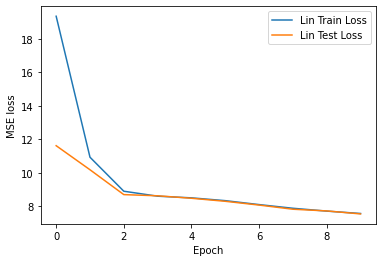

In [26]:
multi_lin_model = DNA_Linear_Multi(seq_len, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.001) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses, val_losses = fit(epochs, multi_lin_model, loss_func, optimizer, train_dl, test_dl)

multi_lin_data_label = list(zip([train_losses,val_losses], ['Lin Train Loss','Lin Test Loss']))
u.quick_loss_plot(multi_lin_data_label)

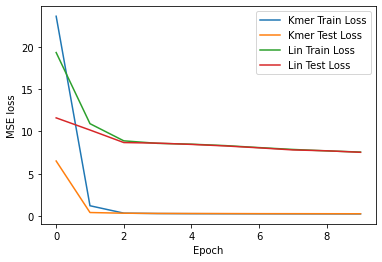

In [27]:
u.quick_loss_plot(kmer_lin_data_label + multi_lin_data_label)

In [28]:
def quick_seq_pred_multi(model, seqs):
    '''Given some sequences, get the model's predictions '''
    for dna in seqs:
        s = torch.tensor(u.one_hot_encode(dna))
        pred = [x.item() for x in model(s.float())]
        print(dna, pred)
        

def quick_test8(model):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        quick_seq_pred_multi(model, seqs)
        print()

In [29]:
quick_test8(multi_lin_model)

AAAAAAAA [19.94623565673828, 20.573719024658203, 19.506444931030273]
CCCCCCCC [16.984243392944336, 15.517560005187988, 18.508460998535156]
GGGGGGGG [14.07850170135498, 9.226743698120117, 18.776094436645508]
TTTTTTTT [11.048409461975098, 17.2071475982666, 4.754807949066162]

AACCAACA [18.848024368286133, 18.558204650878906, 19.24883460998535]
CCGGCGCG [15.454244613647461, 8.46173095703125, 22.35954475402832]
GGGTAAGG [15.122926712036133, 14.30979061126709, 15.935315132141113]
TTTCGTTT [12.164989471435547, 14.489270210266113, 9.76414680480957]
TGTAATAC [15.506141662597656, 18.73706817626953, 12.308951377868652]

TATAAAAA [17.7022705078125, 19.895465850830078, 15.67246150970459]
CCTATCCC [15.864768028259277, 18.812633514404297, 12.969548225402832]
GTATGGGG [14.033514022827148, 13.697497367858887, 14.30917739868164]
TTTATTTT [12.203829765319824, 19.93817901611328, 4.4820685386657715]

AAGCGAAA [18.087499618530273, 14.754141807556152, 21.53849220275879]
CGCGCCCC [16.237672805786133, 10.0098

### Try CNN running??

In [30]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3,
                 lin_share_size=10
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_share = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), lin_share_size),
            nn.ReLU(inplace=True),
        ) 
        
        # define the multi task objectives?
        self.obj0  = nn.Linear(lin_share_size,1)
        self.obj1  = nn.Linear(lin_share_size,1)
        self.obj2  = nn.Linear(lin_share_size,1)
        
        
    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        
        out = self.conv_share(xb)
        
        out0 = self.obj0(out)
        out1 = self.obj1(out)
        out2 = self.obj2(out)
        
        return (out0, out1, out2)
        # ^^ where does this go and what does it do?

Epoch: 0
0 9.378896051912655
Epoch: 1
1 8.212160656137149
Epoch: 2
2 6.5172116399211495
Epoch: 3
3 4.278707288407974
Epoch: 4
4 2.7613494533716922
Epoch: 5
5 2.069691384824486
Epoch: 6
6 0.9463077384886452
Epoch: 7
7 0.39785297259092695
Epoch: 8
8 0.3403865290617557
Epoch: 9
9 0.6774513458638137


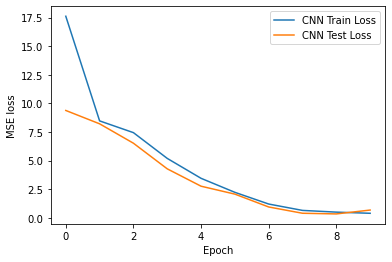

In [31]:
seq_len = len(train_df['seq'][0])
multi_cnn_model = DNA_CNN_Multi(seq_len)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_cnn_model.parameters(), lr=0.001) 

epochs = 10
train_dl,test_dl = dls['multi_ohe']
train_losses_cnn, val_losses_cnn = fit(epochs, multi_cnn_model, loss_func, optimizer, train_dl, test_dl)

multi_cnn_data_label = list(zip([train_losses_cnn,val_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(multi_cnn_data_label)

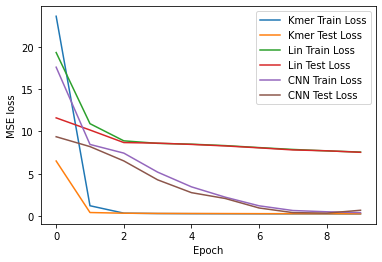

In [32]:
u.quick_loss_plot(kmer_lin_data_label + multi_lin_data_label + multi_cnn_data_label)

In [33]:
quick_test8(multi_cnn_model)

AAAAAAAA [20.139726638793945, 19.145456314086914, 21.18766212463379]
CCCCCCCC [17.11123275756836, 16.936140060424805, 17.29840087890625]
GGGGGGGG [14.076923370361328, 12.83683967590332, 15.422852516174316]
TTTTTTTT [11.387174606323242, 10.867471694946289, 11.899430274963379]

AACCAACA [18.71954345703125, 18.292510986328125, 19.3107852935791]
CCGGCGCG [16.088668823242188, 1.683077096939087, 30.24847412109375]
GGGTAAGG [15.388191223144531, 14.373390197753906, 16.467973709106445]
TTTCGTTT [12.194446563720703, 11.248783111572266, 13.174957275390625]
TGTAATAC [15.876697540283203, 14.970412254333496, 16.641508102416992]

TATAAAAA [17.826326370239258, 25.852462768554688, 9.785074234008789]
CCTATCCC [15.881200790405273, 24.52114486694336, 7.22174072265625]
GTATGGGG [13.766916275024414, 22.417160034179688, 5.180197715759277]
TTTATTTT [12.132444381713867, 20.441091537475586, 3.8560142517089844]

AAGCGAAA [17.98390769958496, 7.637040615081787, 28.44145393371582]
CGCGCCCC [16.07155418395996, 5.987

# inspect

### cnn model

In [34]:
multi_cnn_model

DNA_CNN_Multi(
  (conv_share): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=192, out_features=10, bias=True)
    (4): ReLU(inplace=True)
  )
  (obj0): Linear(in_features=10, out_features=1, bias=True)
  (obj1): Linear(in_features=10, out_features=1, bias=True)
  (obj2): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
conv_layers, model_weights, bias_weights = u.get_conv_layers_from_model(multi_cnn_model)

Total convolutional layers: 1


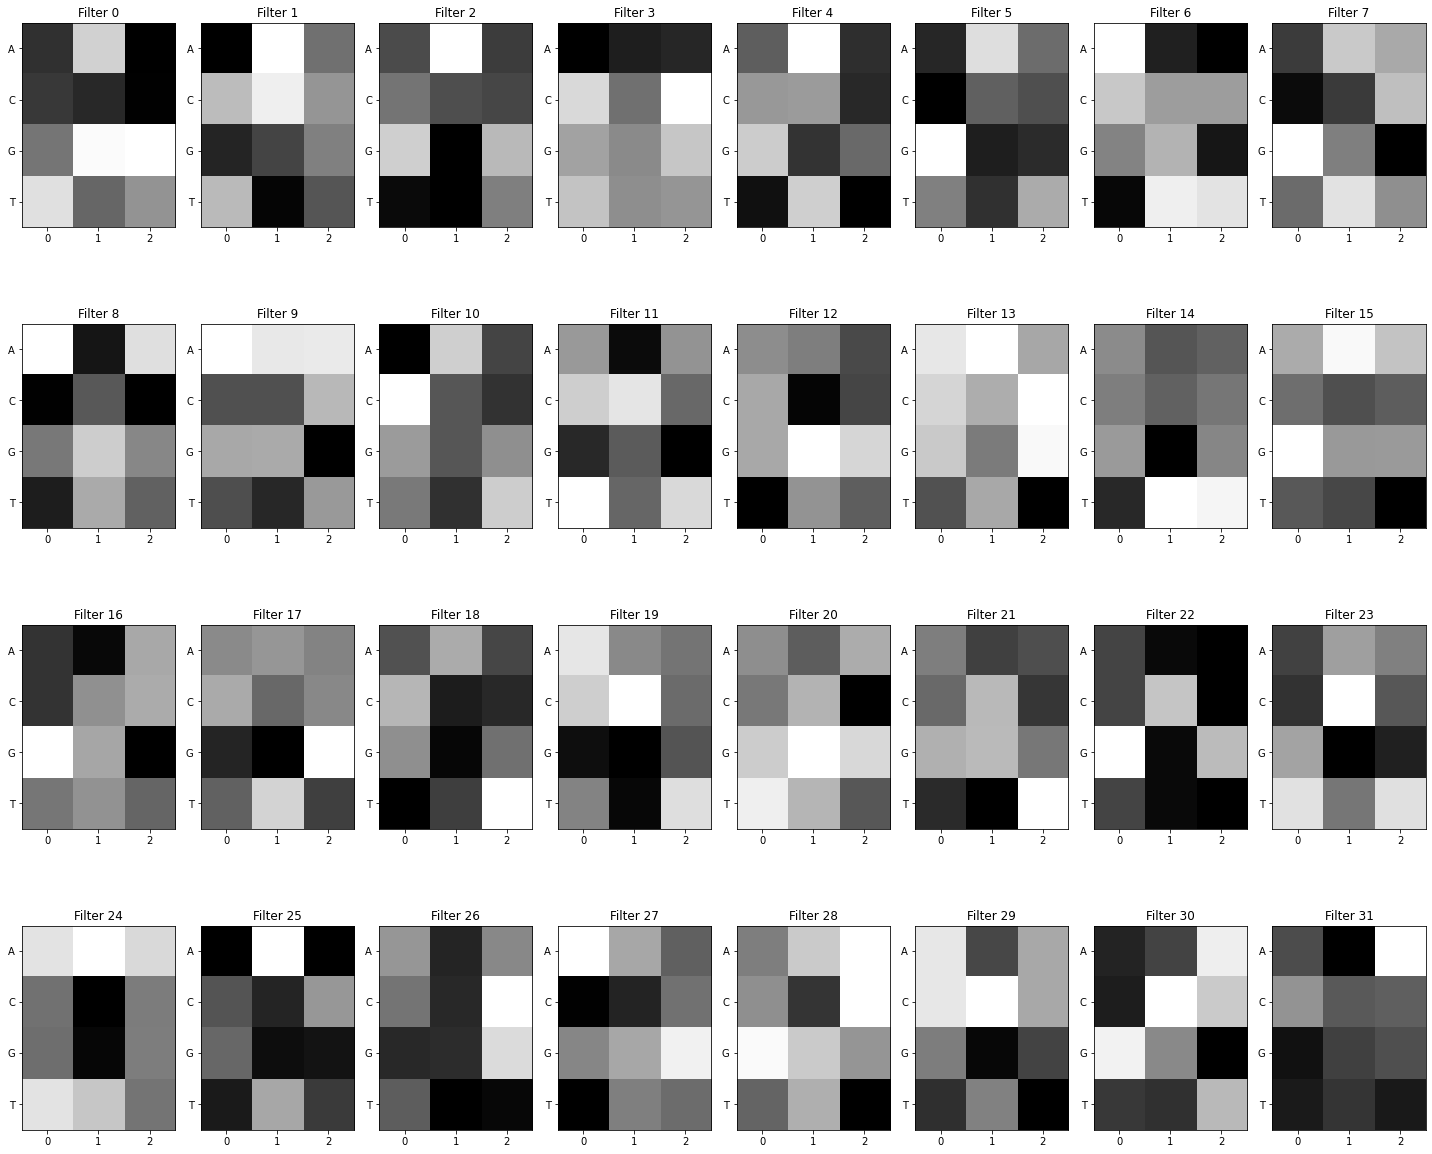

In [36]:
u.view_filters(model_weights)

In [38]:
seqs8_5k = u.downselect_list(seqs8,5000)
filter_activations = u.get_filter_activations(seqs8_5k, conv_layers[0])

Running seq AGGTCGGA
Running seq AAAAACAG
Running seq TTGTGGAG
Running seq AGCTAGGC
Running seq AACTTATA
Running seq GGCAGCCC
Running seq TTAGCCTA
Running seq GCAACGCC
Running seq ATGTCTGT
Running seq CGGCACGT
Running seq CGCCTTAC
Running seq GTAAATAA
Running seq TTGGGGCA
Running seq TAAGCAGA
Running seq GGCATCAA
Running seq GACGACAG
Running seq AATACCTA
Running seq GCGTTCGT
Running seq AGCGTACC
Running seq TGCGTCAA
Running seq AAACCTTG
Running seq TCAGCGAG
Running seq AGCAAGGT
Running seq GTATCCCA
Running seq CTAACTAA
Running seq AACAAACC
Running seq AGCGCCCA
Running seq GCTCCGTA
Running seq ACAGGCGA
Running seq TCCTGAGC
Running seq GAGTAGTG
Running seq AACCTTTA
Running seq GGGTTCCG
Running seq GGTACTGC
Running seq AGCCTTTT
Running seq TCCTCACT
Running seq CTCGCCAT
Running seq ACGTATCG
Running seq TCGGCTAT
Running seq CGGATGAT
Running seq CGCTCCGA
Running seq AAATGTCA
Running seq AAGGTTTC
Running seq GAGGAGCT
Running seq TCCCATAT
Running seq CATCTTGA
Running seq TGCGGAAG
Running seq A

Running seq ATAACGTG
Running seq ACTGAGCG
Running seq GACGAATT
Running seq GTCCTGGT
Running seq GCGAAGAA
Running seq CTACCGCT
Running seq GCTATGAC
Running seq GTGATATG
Running seq TGACACCG
Running seq CCTAAATA
Running seq ACCTATGC
Running seq TTACGTAT
Running seq TAGGCCTG
Running seq TAAACAAT
Running seq CAGTGGGG
Running seq CGGGTTGA
Running seq AGAGGTAG
Running seq CTACATCA
Running seq GTGACATA
Running seq TGACTATC
Running seq ATCTTCTC
Running seq CTGGCGCG
Running seq GTGTCCGC
Running seq AGATGCGC
Running seq CTAGTATC
Running seq GTCTTCGG
Running seq ATCTTAGC
Running seq CCCCTATC
Running seq CACCTATG
Running seq GGTCATGC
Running seq CGCTAGAT
Running seq GACTGCGG
Running seq GGTGCTGT
Running seq GCTTTTCA
Running seq CGCCCCAA
Running seq TGATGTGC
Running seq GACACATA
Running seq TCCGATGT
Running seq TGTGGGGG
Running seq TTGCGTAC
Running seq GGGGAATA
Running seq CCTGGAAT
Running seq GGCTCAAA
Running seq GATTGCAT
Running seq CTTAGGTG
Running seq CGGCAAAT
Running seq CTGAAAAT
Running seq T

Running seq GTTGCGTC
Running seq TATCATCT
Running seq CTCGTATG
Running seq CTAACCAG
Running seq CGGTTAGG
Running seq GCATCCGG
Running seq CGGTCGGT
Running seq TAACACGA
Running seq TATAGCTA
Running seq AGTGCGAT
Running seq TAACGCTA
Running seq GACGACCA
Running seq GTCTTCTA
Running seq CCGAGTAC
Running seq GGTGTAGA
Running seq ACCTCCAA
Running seq TCAACCAT
Running seq GCACGCCC
Running seq CCTCGCTG
Running seq GCCTTGCA
Running seq GTTATCAC
Running seq GTCGCAAA
Running seq TAGTTCGG
Running seq CCCGGCCA
Running seq TAGTTAAA
Running seq GAACATGC
Running seq CTTAGAAT
Running seq GGTCATCG
Running seq ATGAAGGG
Running seq TTAACGAG
Running seq AACTGTCA
Running seq CACCGGTA
Running seq TACAACCG
Running seq ACGAGACG
Running seq TCTGCGCC
Running seq GCTGCTAG
Running seq TTCCCGTG
Running seq ACATTGAG
Running seq TTACTTGC
Running seq CGTGCTGA
Running seq AGAACGTT
Running seq ATGGTGAC
Running seq CGTCTGCC
Running seq ATACCAGA
Running seq CGGCACTG
Running seq GAACAGTT
Running seq GACATTAA
Running seq G

Running seq ACCAACAG
Running seq AACACTCA
Running seq GATTTGCA
Running seq TTGTCTTA
Running seq AGTGATAT
Running seq CGTAACCC
Running seq CGACACCC
Running seq GTTCTCGA
Running seq AAGATTAC
Running seq GACGTCCC
Running seq CGTTTCGT
Running seq GTACAAAG
Running seq GCAAGACC
Running seq TTCCCCTA
Running seq CCAGGCGA
Running seq CGTGTACC
Running seq AGGCAGGC
Running seq GGCATTAC
Running seq AGCAAATA
Running seq GGCTGTTA
Running seq TCCATTAA
Running seq GACGTCAG
Running seq CTCTGTCT
Running seq GAAAAGGG
Running seq CAAGTCAC
Running seq AACTTGGA
Running seq TGCTACAA
Running seq GAACTTGG
Running seq CTCTTCAA
Running seq CTCGCAAA
Running seq CTGTAAAG
Running seq GCGTCTGC
Running seq CCGTGGCC
Running seq AACGGGAG
Running seq TAACCATA
Running seq CTCGGACC
Running seq AAGTTTTT
Running seq CTGCGAAT
Running seq AACGATCG
Running seq CAGCTCTT
Running seq ACTAGTGA
Running seq CTAGTCGA
Running seq ATTTCAGT
Running seq GTGTCTAG
Running seq GACCAACT
Running seq GCCGTTTC
Running seq GAGTGTAA
Running seq G

Running seq TGATATTT
Running seq GACAGATT
Running seq AAGCCGAT
Running seq GAGTCGCC
Running seq AGCACAAT
Running seq ACACTACA
Running seq TACTCTTT
Running seq GTTTCAGA
Running seq CGTACTTC
Running seq AAATCAAT
Running seq ACTAACCC
Running seq TTATGCAA
Running seq ATATGTTC
Running seq TAGTCCTG
Running seq TAATCATG
Running seq GATACGAA
Running seq CCTGAAAT
Running seq AATATAGA
Running seq GTCCGTCC
Running seq TTGACGTT
Running seq CGTTGGTG
Running seq ACTGATCC
Running seq CAGTCTTT
Running seq GTGTTGTC
Running seq TAAACAGA
Running seq TGACATAC
Running seq CCCAGATG
Running seq CCGCGTCT
Running seq TTCCACAA
Running seq ACAGGATT
Running seq ATGGATTT
Running seq CGGAAGCT
Running seq GCATATTC
Running seq TCGCTCAA
Running seq ACTCAGTT
Running seq CGACGCGA
Running seq GGGATATT
Running seq CACGCACA
Running seq CCCGTCGC
Running seq TCGTGCAG
Running seq TCGCCGCC
Running seq CGTACCAA
Running seq AACGGAGG
Running seq AATAGCTG
Running seq ATTATTTA
Running seq GGACGGTA
Running seq GACGAAAC
Running seq G

Running seq TGGATCCG
Running seq TCTCTACA
Running seq ATAATGAG
Running seq CACCACGC
Running seq GATAAAAC
Running seq GCTTTCGT
Running seq GACTCAAC
Running seq AATCGGTA
Running seq GCGCAAAC
Running seq CTACAAAT
Running seq GCCCGGCA
Running seq ATCCAAAA
Running seq CAATGACG
Running seq TGGAAAAC
Running seq TACCGGGG
Running seq CAGGGCCG
Running seq TACCCCAC
Running seq CCCTGCGG
Running seq CAAGGAGG
Running seq AGCTTCGT
Running seq ACAACGCT
Running seq AGAGTGAC
Running seq CGCACCAT
Running seq TTGACTCA
Running seq GTGGTGAG
Running seq TCATATCG
Running seq ATTTCATC
Running seq CAACGGCT
Running seq GACTACTA
Running seq AGAGTACC
Running seq GGGCGGTC
Running seq GTCTCTTG
Running seq AGAGCAGA
Running seq AATGGTGT
Running seq GATCGTAG
Running seq TCTCCTTT
Running seq CAGCGTTA
Running seq GAATCTAC
Running seq CAACTAAA
Running seq TTTAGGAG
Running seq CTACAAGA
Running seq TTTGATTT
Running seq ATAGGCTC
Running seq TGAGTCAT
Running seq CGGTTGAC
Running seq AATATATA
Running seq TTTGGCCG
Running seq C

Running seq CCCCCCCT
Running seq CACGTACA
Running seq GCTTTGCA
Running seq GTCATCTG
Running seq ACACCACC
Running seq GAAGTAAG
Running seq CACTTCAA
Running seq CTTGGGCT
Running seq TACATAGA
Running seq GAATGGTG
Running seq CCTTCTCC
Running seq TTGACATT
Running seq ACTACAAC
Running seq CACACTAG
Running seq GAGTATCG
Running seq CCCCGCGG
Running seq GTAGGTCT
Running seq GACTCATC
Running seq TTCCCCGG
Running seq CGAGGGTG
Running seq TCATCAAC
Running seq ACATAAGC
Running seq ATCCGAGT
Running seq CTCCGCAC
Running seq TTCATAGC
Running seq CTGCTCGA
Running seq TATTGGCC
Running seq TCCGCACC
Running seq CAATGACT
Running seq TTAGGTAA
Running seq TAACACGT
Running seq ACATCGCC
Running seq ACAACTCG
Running seq ATCTTAGG
Running seq CGTGAAGG
Running seq TATTAGCT
Running seq TTCACGTG
Running seq TAAACCAG
Running seq CATTCCGA
Running seq CTGCTCAT
Running seq GGGATTGT
Running seq ACGTATAA
Running seq AGTACCTC
Running seq GTGTGCGG
Running seq TGTTGAGA
Running seq TGTTCTAT
Running seq ATGCACAG
Running seq C

Running seq CGTGGGTC
Running seq TCCTTGAG
Running seq ACAGATGA
Running seq GTAATCAC
Running seq CGTTCGGC
Running seq ACCACATA
Running seq AGTAAGTA
Running seq CCTGATAA
Running seq ATCTTGGA
Running seq CTGTGAGT
Running seq CCAGACAC
Running seq AACGTTGG
Running seq TGAATGAG
Running seq CGACAGAG
Running seq AACATTCC
Running seq GGGACAAC
Running seq TGAGGACA
Running seq GATGGCCG
Running seq CCGTGTCC
Running seq GACCCCCC
Running seq CAGTGGCC
Running seq GTTCAACG
Running seq ATAAAGTT
Running seq AATCCTTA
Running seq TACCTTGC
Running seq ACCGGCGA
Running seq CAGTCGGG
Running seq TTGTCAGG
Running seq AAATGAAG
Running seq CCGGCACC
Running seq GGACAATA
Running seq CACTACCC
Running seq ATACGAAG
Running seq CATTCGGC
Running seq TCTCTCTA
Running seq ACTCTGAA
Running seq TCTCGATA
Running seq ACGGGGGG
Running seq TTCGTCTG
Running seq GGCAAGGG
Running seq GTGACACA
Running seq GATATCTC
Running seq AAGCTAGT
Running seq GTCACACT
Running seq GTTGCTTG
Running seq ATTCTGGA
Running seq GTATCCCC
Running seq C

Running seq TACTGTGC
Running seq TCGCAATA
Running seq ATAGCAGA
Running seq CTGGCTCG
Running seq CACACACG
Running seq AGATGAAA
Running seq ACCATGCA
Running seq GTAAGTTT
Running seq GGTATAAA
Running seq GTGTTGTT
Running seq CAGAGACT
Running seq TGCCACAC
Running seq CTTGATCC
Running seq GTTAACGG
Running seq ACGGTGTG
Running seq TACAGATG
Running seq GTGCACCA
Running seq ATACACGA
Running seq ACTGGAGG
Running seq ACCTTGCG
Running seq AGACAACT
Running seq CAGGCTCC
Running seq ACAAAACA
Running seq GTTGCTTA
Running seq TCTTCTTA
Running seq CCCCGATG
Running seq CATTGCAA
Running seq GGCACCCT
Running seq GAACCATC
Running seq ATCGGCGA
Running seq AAACTTTT
Running seq AGTCGATC
Running seq CTGTGTTA
Running seq GCACGCTA
Running seq GTCCAAAC
Running seq CCTAGATT
Running seq CACAAGGG
Running seq GGCACAGT
Running seq CGGGTTCT
Running seq GAAAGACT
Running seq TGTAACGC
Running seq CAATTCGA
Running seq CGACGCGC
Running seq ATCAGTGA
Running seq TTCATATG
Running seq TCATGATG
Running seq CGGACCTA
Running seq C

Running seq GAGTATTT
Running seq GTCGGACT
Running seq TTTCTCCG
Running seq GACAACGA
Running seq CATTGCAG
Running seq TCAAGTGG
Running seq CCCCGTCT
Running seq CCCTACGT
Running seq GTGCGTTT
Running seq CATAGTGG
Running seq TGCAATGT
Running seq GAAAAATA
Running seq CCATTATA
Running seq CGTGTTGC
Running seq GTGGGACT
Running seq AACGCAAG
Running seq ATCCTCGG
Running seq CACCTTCG
Running seq AGTAATTG
Running seq ATACACGT
Running seq CCAATCAA
Running seq ACCTCCGG
Running seq GGACAGCC
Running seq CCCTCATT
Running seq GATCACAG
Running seq GGCGCACG
Running seq ACCGACTC
Running seq AGATTACG
Running seq TGTTCTAA
Running seq TCAACAGG
Running seq ATGAGCCA
Running seq TGGTACTT
Running seq CGCAGGAA
Running seq GAACACAT
Running seq AGCACATA
Running seq AAACTAGC
Running seq ATTCTTGG
Running seq AGAAGGTA
Running seq GTGCGAGT
Running seq TCACGCCC
Running seq CTTTTCTC
Running seq AACGTAGG
Running seq ATTTCTTT
Running seq AAGCCAAA
Running seq CCTAGGAA
Running seq TGGTGGGG
Running seq CACCTTGA
Running seq C

Running seq GTCGTCGA
Running seq TACGTTAT
Running seq GGACTCTT
Running seq GATTCAGT
Running seq AACGCCTA
Running seq TGGGAGAG
Running seq TGGCAGAG
Running seq CGCGGTAT
Running seq TCTCGAGT
Running seq CTTTAAGC
Running seq ACTGATTT
Running seq AACGGGGA
Running seq AGCGTACG
Running seq GCAAACAC
Running seq CCTTGATT
Running seq GGCATTTG
Running seq CGGTGGCG
Running seq GCGCAGTA
Running seq GCGAAAGT
Running seq ATATTGGA
Running seq AGAGGCAT
Running seq TATCGAAG
Running seq TAGCTACT
Running seq ATGCGGTG
Running seq GTAACACC
Running seq CTCCTTTT
Running seq TAATCGAC
Running seq TGGGTCTG
Running seq TTTTGTTA
Running seq GAGCCACC
Running seq AGGTTTCA
Running seq CAAATAAC
Running seq GGCCACGC
Running seq AAGTACCG
Running seq TGAGATCC
Running seq TTTCATTA
Running seq CACGACTG
Running seq CAGTGATA
Running seq ACGAAACA
Running seq ATCAAATC
Running seq AAGCCCCG
Running seq AGCCTCGG
Running seq TGATTTTG
Running seq TCCAGGCA
Running seq TAGCTACC
Running seq ATTGGGCT
Running seq GCAAGGTT
Running seq T

Running seq GTGGCCAG
Running seq ACAGTGCG
Running seq GTTAGACC
Running seq GGTGCTTC
Running seq ACGTCGGC
Running seq GTAGCCCG
Running seq GACAAGAT
Running seq TGAGATTT
Running seq CTCCAGTA
Running seq AAGTCCTA
Running seq GTACGATT
Running seq TCCTTGGG
Running seq TCGCAGCA
Running seq AGACCAGT
Running seq TGTACGAT
Running seq CCCAAAAA
Running seq TACGTGGA
Running seq TATATAGG
Running seq ATGACTAA
Running seq CTCCTAAG
Running seq TTCTTTCT
Running seq ACACTGGA
Running seq GTCCGGAT
Running seq TGCTATTA
Running seq ATTCGGCT
Running seq GGCCTAAA
Running seq GAAACCTC
Running seq AGGACCCC
Running seq ACGCAAAC
Running seq CGACATTG
Running seq TTTCGGTC
Running seq AGAAAGCA
Running seq TAAAACCG
Running seq CCTGCTTG
Running seq GTGCTTTC
Running seq AGGCGAGC
Running seq CCGTGTCG
Running seq ATTGCATG
Running seq AGGCCTAG
Running seq AGCATGAT
Running seq GAACATGA
Running seq TGCGAAGG
Running seq ACTGCACG
Running seq TACGACAT
Running seq TCCCTATG
Running seq CTGCGTGA
Running seq ATTGATCG
Running seq A

Running seq TGATCTTC
Running seq GTTCGTTC
Running seq CTCTAAAG
Running seq GGAGACGC
Running seq GACACACA
Running seq AGCAGTAA
Running seq AAGCCACA
Running seq ACCGCCCG
Running seq CTCTTAAT
Running seq ATCAGGCT
Running seq CTCCCCGC
Running seq AGACATGA
Running seq CGCGACTG
Running seq TGAGACCC
Running seq CTGAAACT
Running seq GCGAGGTG
Running seq AAGGGATC
Running seq GACGGAAT
Running seq TGGGGTTC
Running seq GGCTGTAA
Running seq TGAGCCAT
Running seq CGTTGTGA
Running seq GCAAGTCT
Running seq CCTACCTG
Running seq TTGGTAAG
Running seq AAGTTGCT
Running seq CTGTTCCG
Running seq TTCAGATA
Running seq GACTGCCA
Running seq ACCCCATT
Running seq ACGCGCGA
Running seq GTTACGAA
Running seq TGGCAAAC
Running seq TGAAAAAT
Running seq TGGCTCTA
Running seq CCATAATA
Running seq CTCACCGA
Running seq TCTCCCAT
Running seq ACCTCTAG
Running seq AAACATGG
Running seq GTAAATGA
Running seq AACTAATA
Running seq CTGCTATC
Running seq TACGCTTT
Running seq CACACCCC
Running seq TTGCCAAT
Running seq AAAAGGTA
Running seq G

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


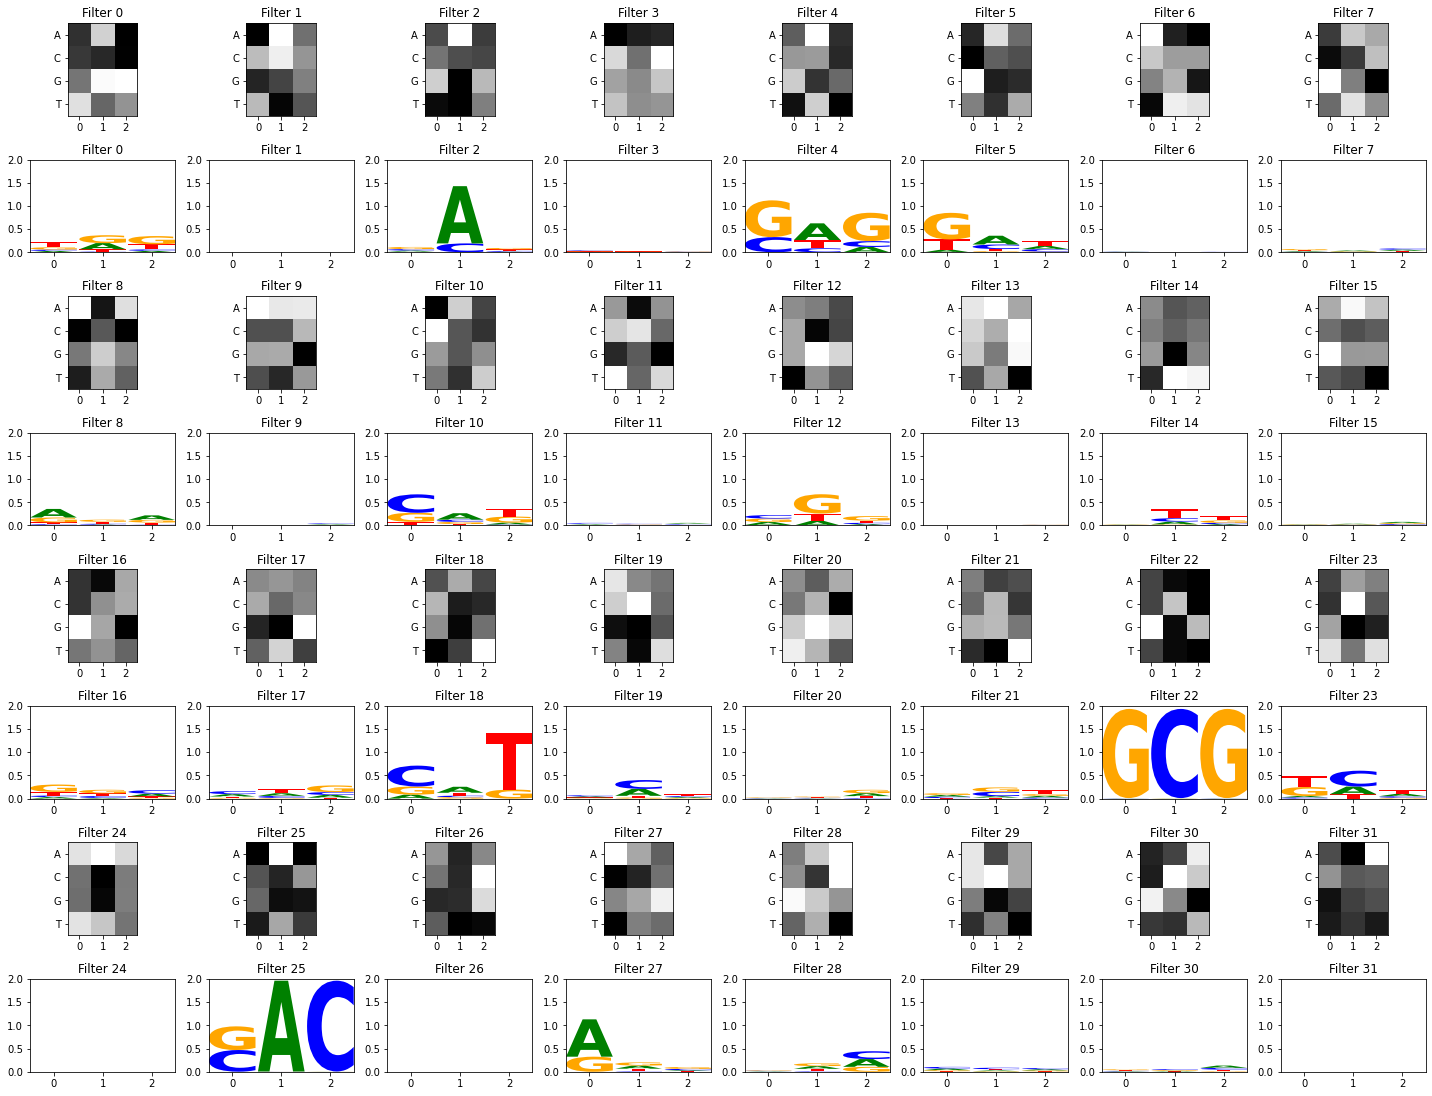

In [39]:
u.view_filters_and_logos(model_weights,filter_activations)